In [85]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import hvplot.pandas
from joblib import dump, load
import asyncio

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option("display.max_rows", 2000)

In [86]:
from fuzzywuzzy import process
import requests

In [87]:
r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
stockList = r.json()


In [88]:
#load model for results
model = load('project2_random_forest_model.joblib')

In [89]:
#possible inputs from user
company_request = 'ford'
cash_amount = '1000'
shares_wanted = 1000 

In [90]:
def getCompany(text):
    return process.extractOne(text, stockList)[0]

In [91]:
company = getCompany(company_request)

In [92]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

AHT
ASHFORD HOSPITALITY TRUST


In [93]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 completed


# Daily returns


In [94]:
# Import `numpy` as `np`
import numpy as np

# Assign `Adj Close` to `daily_close`
daily_close = data[['Adj Close']]

# Daily returns
daily_pct_change = daily_close.pct_change()

# Replace NA values with 0
daily_pct_change.fillna(0, inplace=True)

# Inspect daily returns
#print(daily_pct_change)
daily_pct_change.head()


,Adj Close
Date,
2003-08-26,0.000000
2003-08-27,0.008889
2003-08-28,0.017621
2003-08-29,0.000000
2003-09-02,-0.008658


In [95]:
# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)

# Print daily log returns
#print(daily_log_returns)
daily_log_returns.head()

,Adj Close
Date,
2003-08-26,NaN
2003-08-27,0.008850
2003-08-28,0.017467
2003-08-29,0.000000
2003-09-02,-0.008696



# Calculating monthly or quarterly returns using resample()

In [96]:
# Resample `data` to business months, take last observation as value 
monthly = data.resample('BM').apply(lambda x: x[-1])

# Calculate the monthly percentage change
#monthly.pct_change()
monthly.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-08-29,5.786410,5.786410,5.736311,5.786410,1.632049,468700
2003-09-30,5.604802,5.636114,5.604802,5.617327,1.584360,328600
2003-10-31,5.730049,5.792673,5.730049,5.730049,1.616152,216900
2003-11-28,5.949232,5.949232,5.924182,5.949232,1.677972,13400
2003-12-31,5.886608,5.917920,5.855296,5.880346,1.658543,219300


In [97]:
# Resample `data` to quarters, take the mean as value per quarter
quarter = data.resample("4M").mean()

# Calculate the quarterly percentage change
#quarter.pct_change()
quarter.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-08-31,5.686213,5.736312,5.673688,5.723787,1.614387,2.183700e+06
2003-12-31,5.807776,5.853454,5.767329,5.807997,1.638138,2.534165e+05
2004-04-30,6.069801,6.124426,5.998048,6.067990,1.716152,1.183205e+05
2004-08-31,5.464496,5.520410,5.387558,5.461812,1.571562,2.528810e+05
2004-12-31,6.102843,6.181159,6.035799,6.111389,1.810554,1.302847e+05


# The cumulative daily rate

The cumulative daily rate of return is useful to determine the value of an investment at regular intervals. You can calculate the cumulative daily rate of return by using the daily percentage change values, adding 1 to them and calculating the cumulative product with the resulting values:

In [98]:
# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_change).cumprod()

# Print `cum_daily_return`
#print(cum_daily_return)
cum_daily_return.head()

,Adj Close
Date,
2003-08-26,1.000000
2003-08-27,1.008889
2003-08-28,1.026667
2003-08-29,1.026667
2003-09-02,1.017778


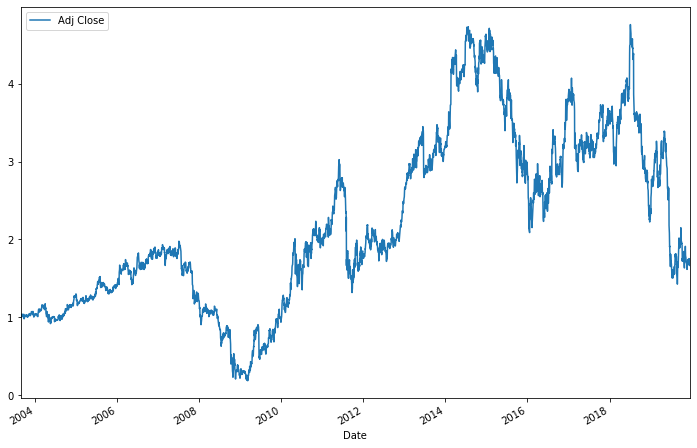

In [99]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(12,8))

# Show the plot
plt.show()

In [100]:
# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Print the `cum_monthly_return`
#print(cum_monthly_return)
cum_monthly_return.head()

,Adj Close
Date,
2003-08-31,1.015556
2003-09-30,1.018307
2003-10-31,1.019565
2003-11-30,1.035497
2003-12-31,1.049243


In [101]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [102]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 50
long_vol_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

# Set the short window and long windows
rolling_short_window = 50
rolling_long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
data["SMA50"] = data["Close"].rolling(window=short_window).mean()
data["SMA100"] = data["Close"].rolling(window=long_window).mean()

# Initialize the new `Signal` column
data["SMA_Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
data["SMA_Signal"][short_window:] = np.where(
    data["SMA50"][short_window:] < data["SMA100"][short_window:], 1.0, 0.0
)

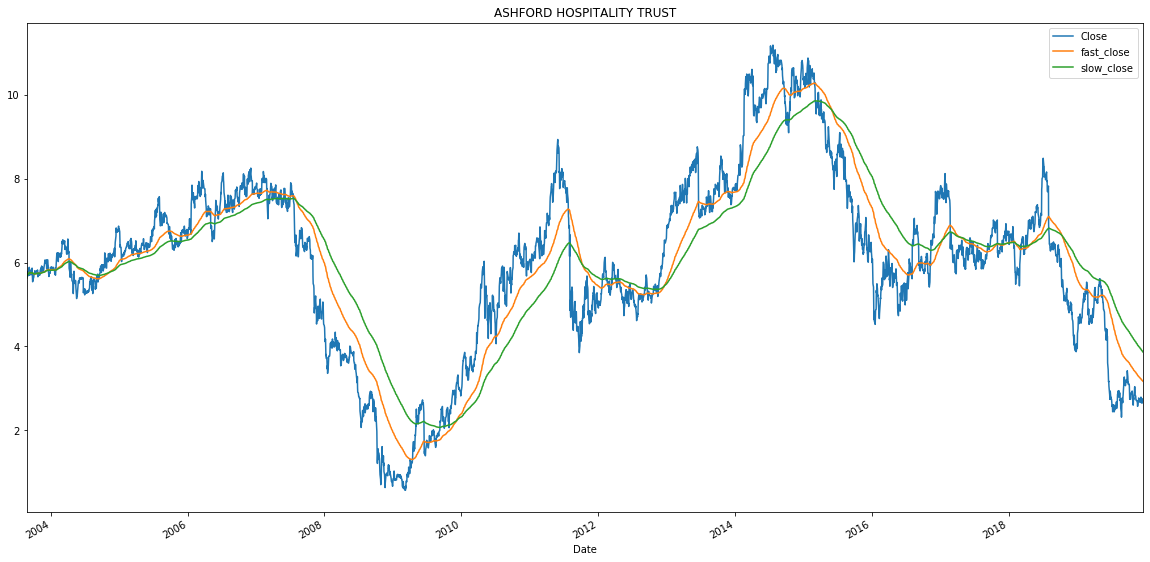

In [103]:
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

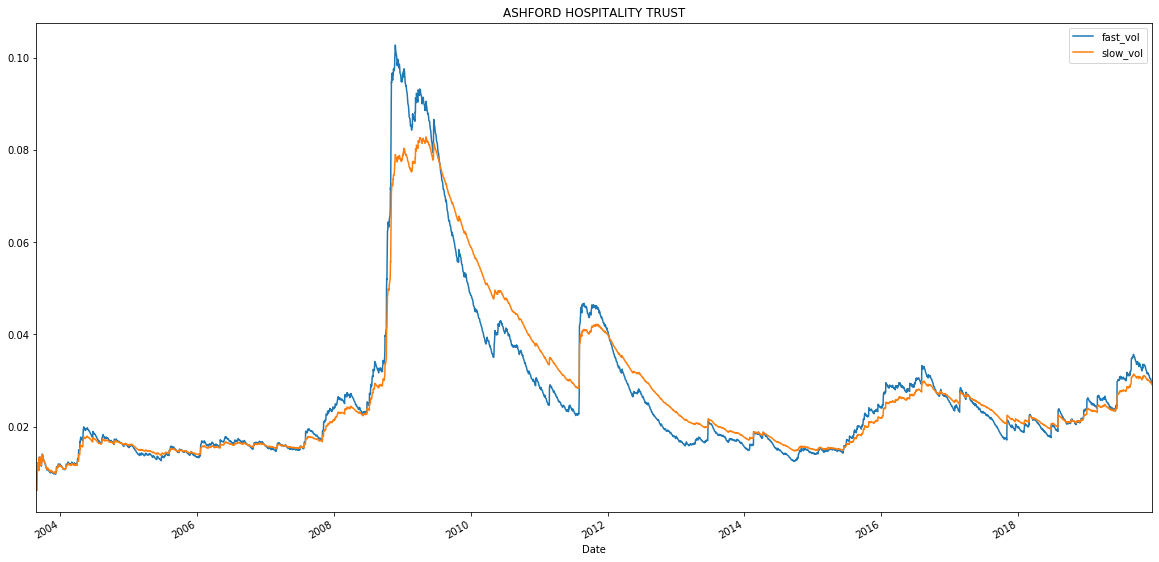

In [104]:
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

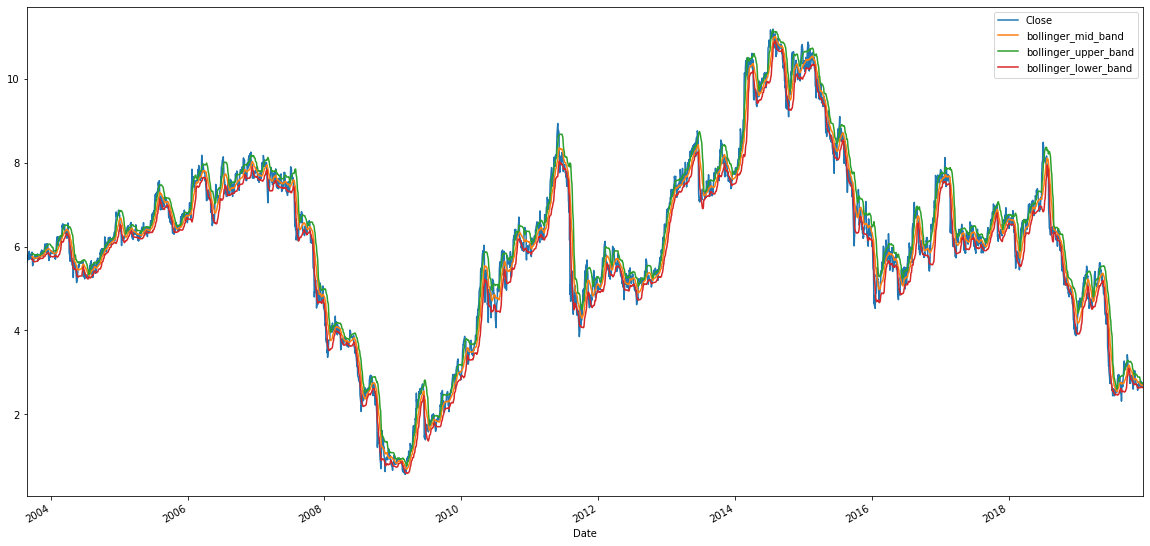

In [105]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [106]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'SMA_Signal']
data[x_var_list] = data[x_var_list].shift(1)

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-13,-1.0,-1.0,0.0,1.0
2019-12-16,-1.0,-1.0,0.0,1.0
2019-12-17,-1.0,-1.0,0.0,1.0
2019-12-18,-1.0,-1.0,0.0,1.0
2019-12-19,-1.0,-1.0,0.0,1.0


In [107]:
#signal_dataand replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2003-08-27,5.636114,5.686213,5.636114,5.686213,1.603789,1641000,0.008889,5.661337,5.661250,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2003-08-28,5.686213,5.836509,5.686213,5.786410,1.632049,683700,0.017621,5.703608,5.703260,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2003-08-29,5.786410,5.786410,5.736311,5.786410,1.632049,468700,0.000000,5.724741,5.724264,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2003-09-02,5.736311,5.736311,5.636114,5.736311,1.617918,2651800,-0.008658,5.727119,5.726707,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2003-09-03,5.736311,5.736311,5.686213,5.686213,1.603789,1584800,-0.008734,5.720063,5.719841,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


In [108]:
data['Positive Return'] = np.where(data['Daily Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2003-08-27,5.636114,5.686213,5.636114,5.686213,1.603789,1641000,0.008889,5.661337,5.661250,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2003-08-28,5.686213,5.836509,5.686213,5.786410,1.632049,683700,0.017621,5.703608,5.703260,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2003-08-29,5.786410,5.786410,5.736311,5.786410,1.632049,468700,0.000000,5.724741,5.724264,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2003-09-02,5.736311,5.736311,5.636114,5.736311,1.617918,2651800,-0.008658,5.727119,5.726707,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2003-09-03,5.736311,5.736311,5.686213,5.686213,1.603789,1584800,-0.008734,5.720063,5.719841,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13,2.660000,2.700000,2.630000,2.650000,2.650000,414600,0.000000,3.197452,3.902397,0.0,...,0.051606,2.741606,2.638394,0.0,0.0,0.0,2.785099,2.836028,1.0,0.0
2019-12-16,2.680000,2.710000,2.650000,2.650000,2.650000,508600,0.000000,3.189915,3.893746,0.0,...,0.052123,2.739123,2.634877,0.0,0.0,0.0,2.775846,2.837429,1.0,0.0
2019-12-17,2.650000,2.730000,2.640000,2.700000,2.700000,439400,0.018868,3.183171,3.885500,0.0,...,0.052202,2.739702,2.635299,0.0,0.0,0.0,2.768186,2.838737,1.0,1.0


In [109]:
start_date = data.index.min().strftime(format= '%Y-%m-%d')
end_date = data.index.max().strftime(format= '%Y-%m-%d')

# Construct the datasets
x_data = data[x_var_list][start_date:end_date]

# Predictions

In [110]:
predictions = model.predict(x_data)
predictions

array([1., 1., 1., ..., 0., 0., 0.])

In [111]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
data["Predicted Value"] = predictions
data.tail(10)


,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Predicted Value
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-06,2.70,2.76,2.70,2.73,2.73,397600,0.022472,3.233365,3.944886,0.0,...,2.769753,2.644247,0.0,0.0,0.0,2.836445,2.826029,0.0,1.0,0.0
2019-12-09,2.72,2.80,2.71,2.79,2.79,350800,0.021978,3.227261,3.936909,0.0,...,2.760699,2.647301,0.0,-1.0,0.0,2.823866,2.829522,0.0,1.0,0.0
2019-12-10,2.78,2.80,2.65,2.70,2.70,548100,-0.032258,3.220002,3.928365,0.0,...,2.749415,2.647585,0.0,0.0,-1.0,2.812451,2.832115,1.0,0.0,0.0
2019-12-11,2.72,2.75,2.64,2.70,2.70,658200,0.000000,3.212843,3.919880,0.0,...,2.747378,2.646622,0.0,0.0,0.0,2.803802,2.834213,1.0,0.0,0.0
2019-12-12,2.69,2.73,2.65,2.65,2.65,705300,-0.018519,3.205094,3.911108,0.0,...,2.744622,2.642378,0.0,0.0,0.0,2.793957,2.835417,1.0,0.0,0.0
2019-12-13,2.66,2.70,2.63,2.65,2.65,414600,0.000000,3.197452,3.902397,0.0,...,2.741606,2.638394,0.0,0.0,0.0,2.785099,2.836028,1.0,0.0,0.0
2019-12-16,2.68,2.71,2.65,2.65,2.65,508600,0.000000,3.189915,3.893746,0.0,...,2.739123,2.634877,0.0,0.0,0.0,2.775846,2.837429,1.0,0.0,0.0
2019-12-17,2.65,2.73,2.64,2.70,2.70,439400,0.018868,3.183171,3.885500,0.0,...,2.739702,2.635299,0.0,0.0,0.0,2.768186,2.838737,1.0,1.0,0.0
2019-12-18,2.70,2.74,2.69,2.72,2.72,379900,0.007407,3.176794,3.877450,0.0,...,2.742516,2.637484,0.0,0.0,0.0,2.761321,2.840245,1.0,1.0,0.0


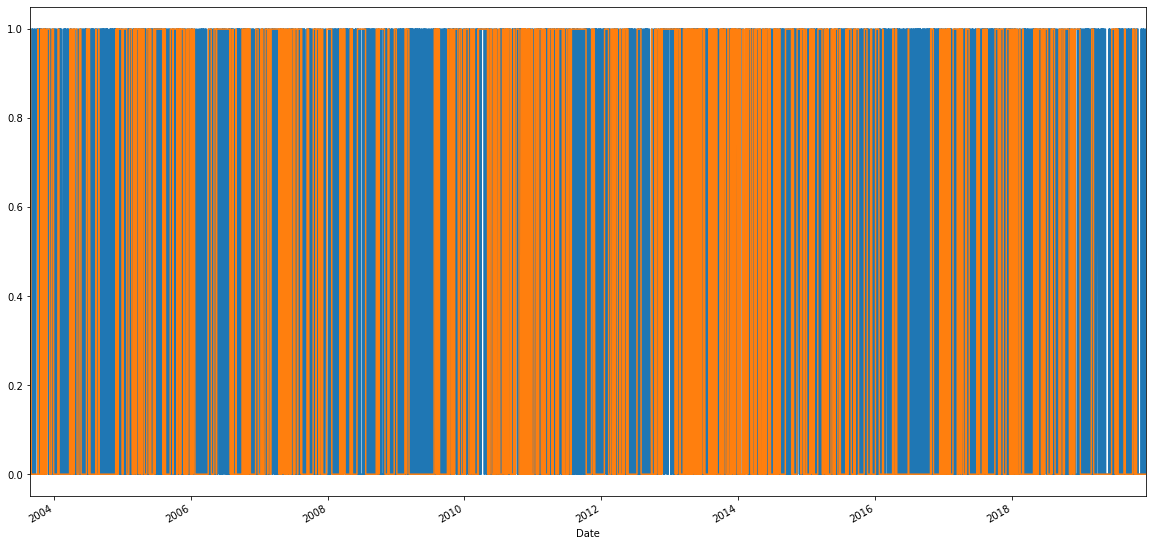

In [112]:
data['Positive Return'][start_date:end_date].plot(figsize=(20,10))
data['Predicted Value'][start_date:end_date].plot(figsize=(20,10))

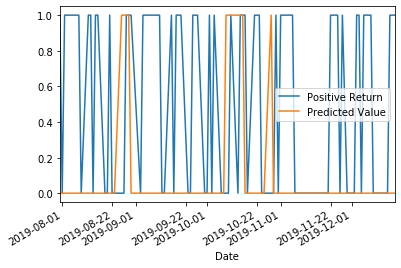

In [113]:
data[['Positive Return', 'Predicted Value']].tail(100).plot()

In [114]:
# Calculate the points in time at which a position should be taken, 1 or -1
data["Entry Exit"] = data["Predicted Value"].diff()

In [115]:
#Visualize exit position relative to close price
exit = data[data['Entry Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = data[data['Entry Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = data[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = data[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis='bottom')

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# PORTFOLIO ANALYSER

In [116]:
#Need to figure out share size based on captial divided by close cost - integer 
#for loop o it always takes the last know value to get latest share size
#for loop through proces

In [117]:
# Grab just the `date` and `close` from the IEX dataset
signals_df = data.loc[:, ['Entry Exit', 'Close']].copy()

# # Set the `date` column as the index
# signals_df = signals_df.set_index("date", drop=True)

# # Set the short window and long windows
# short_window = 50
# long_window = 100

# # Generate the short and long moving averages (50 and 100 days, respectively)
# signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
# signals_df['SMA100'] = signals_df['close'].rolling(window=long_window).mean()
# signals_df['Signal'] = 0.0

# # Generate the trading signal 0 or 1,
# # where 0 is when the SMA50 is under the SMA100, and
# # where 1 is when the SMA50 is higher (or crosses over) the SMA100
# signals_df['Signal'][short_window:] = np.where(
#     signals_df['SMA50'][short_window:] > signals_df['SMA100'][short_window:], 1.0, 0.0
# )

# Calculate the points in time at which a position should be taken, 1 or -1
#signals_df['Entry Exit'] = signals_df['Entry Exit'].diff()

# Print the DataFrame
signals_df

,Entry Exit,Close
Date,,
2003-08-27,NaN,5.686213
2003-08-28,0.0,5.786410
2003-08-29,0.0,5.786410
2003-09-02,-1.0,5.736311
2003-09-03,0.0,5.686213
...,...,...
2019-12-13,0.0,2.650000
2019-12-16,0.0,2.650000
2019-12-17,0.0,2.700000


In [118]:
signals_df["Entry Exit"][0] = 0
signals_df['Position'] = 0
signals_df['Entry/Exit Position'] = 0
signals_df['Portfolio Holdings'] = 0
signals_df['Portfolio Cash'] = 0
signals_df['Portfolio Total'] = 0
signals_df['Portfolio Daily Returns'] = 0
signals_df['Portfolio Cumulative Returns'] = 0


In [119]:
signals_df["Entry Exit"][0] = 0

In [120]:
negative_check = signals_df.loc[signals_df['Entry Exit'] != 0].reset_index()
negative_check[:5]

,Date,Entry Exit,Close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
0,2003-09-02,-1.0,5.736311,0,0,0,0,0,0,0
1,2003-10-09,1.0,5.761361,0,0,0,0,0,0,0
2,2003-10-10,-1.0,5.761361,0,0,0,0,0,0,0
3,2003-10-23,1.0,5.761361,0,0,0,0,0,0,0
4,2003-10-24,-1.0,5.661163,0,0,0,0,0,0,0


In [121]:
if negative_check.iloc[0]['Entry Exit'] < 0:
    x = negative_check.iloc[0]['Date'].strftime(format= '%Y-%m-%d')
    signals_df['Entry Exit'][x] = 0

In [122]:
signals_df

,Entry Exit,Close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,
2003-08-27,0.0,5.686213,0,0,0,0,0,0,0
2003-08-28,0.0,5.786410,0,0,0,0,0,0,0
2003-08-29,0.0,5.786410,0,0,0,0,0,0,0
2003-09-02,0.0,5.736311,0,0,0,0,0,0,0
2003-09-03,0.0,5.686213,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-12-13,0.0,2.650000,0,0,0,0,0,0,0
2019-12-16,0.0,2.650000,0,0,0,0,0,0,0
2019-12-17,0.0,2.700000,0,0,0,0,0,0,0


In [123]:
# Set initial capital
initial_capital = float(cash_amount)
signals_df['Portfolio Cash'][0] = initial_capital 
share_size = int(shares_wanted)


# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals_df['Position'] = share_size * signals_df['Entry Exit']

# Find the points in time where a 500 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].cumsum()

signals_df['Total Entry/Exit Position'] = signals_df['Entry/Exit Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Total Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Total Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals_df[25:100]

,Entry Exit,Close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns,Total Entry/Exit Position
Date,,,,,,,,,,
2003-10-02,0.0,5.648639,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0
2003-10-03,0.0,5.698738,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0
2003-10-06,0.0,5.761361,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0
2003-10-07,0.0,5.742574,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0
2003-10-08,0.0,5.805197,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0
2003-10-09,1.0,5.761361,1000.0,1000.0,5761.361122,-4761.361122,1000.000000,0.000000,0.000000,1000.0
2003-10-10,-1.0,5.761361,-1000.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,-1000.0
2003-10-13,0.0,5.730049,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0
2003-10-14,0.0,5.761361,0.0,0.0,0.000000,1000.000000,1000.000000,0.000000,0.000000,0.0


In [124]:
signals_df['Without Algorithm'] = (int(initial_capital/signals_df['Close'][0])) * signals_df['Close']

In [125]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Entry Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Entry Exit'] == 1]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

#plot if we bought without algorithm
reg_value = signals_df[['Without Algorithm']].hvplot(
    line_color='blue',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit * reg_value 
portfolio_entry_exit_plot.opts(xaxis='bottom')

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)
   .Curve.II                   :Curve   [Date]   (Without Algorithm)

# Evaluating Moving Average Crossover Strategy

In [126]:
# Isolate the returns of your strategy
returns = signals_df['Portfolio Cash'][0] = initial_capital 

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)




AttributeError: 'float' object has no attribute 'mean'

# Abandoned NY Times Sentiment Code